In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
!pip install -q kaggle

In [3]:
!mkdir kaggle
!cd kaggle

In [4]:
!kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class

Dataset URL: https://www.kaggle.com/datasets/mohammadamireshraghi/blood-cell-cancer-all-4class
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 1.68G/1.68G [00:22<00:00, 128MB/s]
100% 1.68G/1.68G [00:22<00:00, 81.7MB/s]


In [5]:
!unzip blood-cell-cancer-all-4class.zip

Archive:  blood-cell-cancer-all-4class.zip
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (1).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (10).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (11).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (12).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (13).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (14).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (15).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (16).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (17).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (18).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (19).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (2).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (20).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (21).jpg  
  inflating: Blood cell Cancer [ALL]/Benign/Sap_013 (23).jpg  
  inflating: B

In [6]:
data_dir = '/content/Blood cell Cancer [ALL]'

filepaths = []
labels = []

# Get only valid directories (ignoring hidden files)
folds = [fold for fold in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, fold)) and not fold.startswith('.')]

# Print the subdirectories to debug the issue
print("Subdirectories found:", folds)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:  # Skipping certain directories
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Display the dataframe
df.head()

Subdirectories found: ['Benign', '[Malignant] Pro-B', '[Malignant] early Pre-B', '[Malignant] Pre-B']


filepaths  labels
0  /content/Blood cell Cancer [ALL]/Benign/Snap_0...  Benign
1  /content/Blood cell Cancer [ALL]/Benign/Snap_1...  Benign
2  /content/Blood cell Cancer [ALL]/Benign/Snap_1...  Benign
3  /content/Blood cell Cancer [ALL]/Benign/Snap_0...  Benign
4  /content/Blood cell Cancer [ALL]/Benign/Snap_0...  Benign

In [7]:
df

filepaths             labels
0     /content/Blood cell Cancer [ALL]/Benign/Snap_0...             Benign
1     /content/Blood cell Cancer [ALL]/Benign/Snap_1...             Benign
2     /content/Blood cell Cancer [ALL]/Benign/Snap_1...             Benign
3     /content/Blood cell Cancer [ALL]/Benign/Snap_0...             Benign
4     /content/Blood cell Cancer [ALL]/Benign/Snap_0...             Benign
...                                                 ...                ...
3237  /content/Blood cell Cancer [ALL]/[Malignant] P...  [Malignant] Pre-B
3238  /content/Blood cell Cancer [ALL]/[Malignant] P...  [Malignant] Pre-B
3239  /content/Blood cell Cancer [ALL]/[Malignant] P...  [Malignant] Pre-B
3240  /content/Blood cell Cancer [ALL]/[Malignant] P...  [Malignant] Pre-B
3241  /content/Blood cell Cancer [ALL]/[Malignant] P...  [Malignant] Pre-B

[3242 rows x 2 columns]

In [8]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()


# Create ImageDataGenerators
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2593 validated image filenames belonging to 4 classes.
Found 389 validated image filenames belonging to 4 classes.
Found 260 validated image filenames belonging to 4 classes.


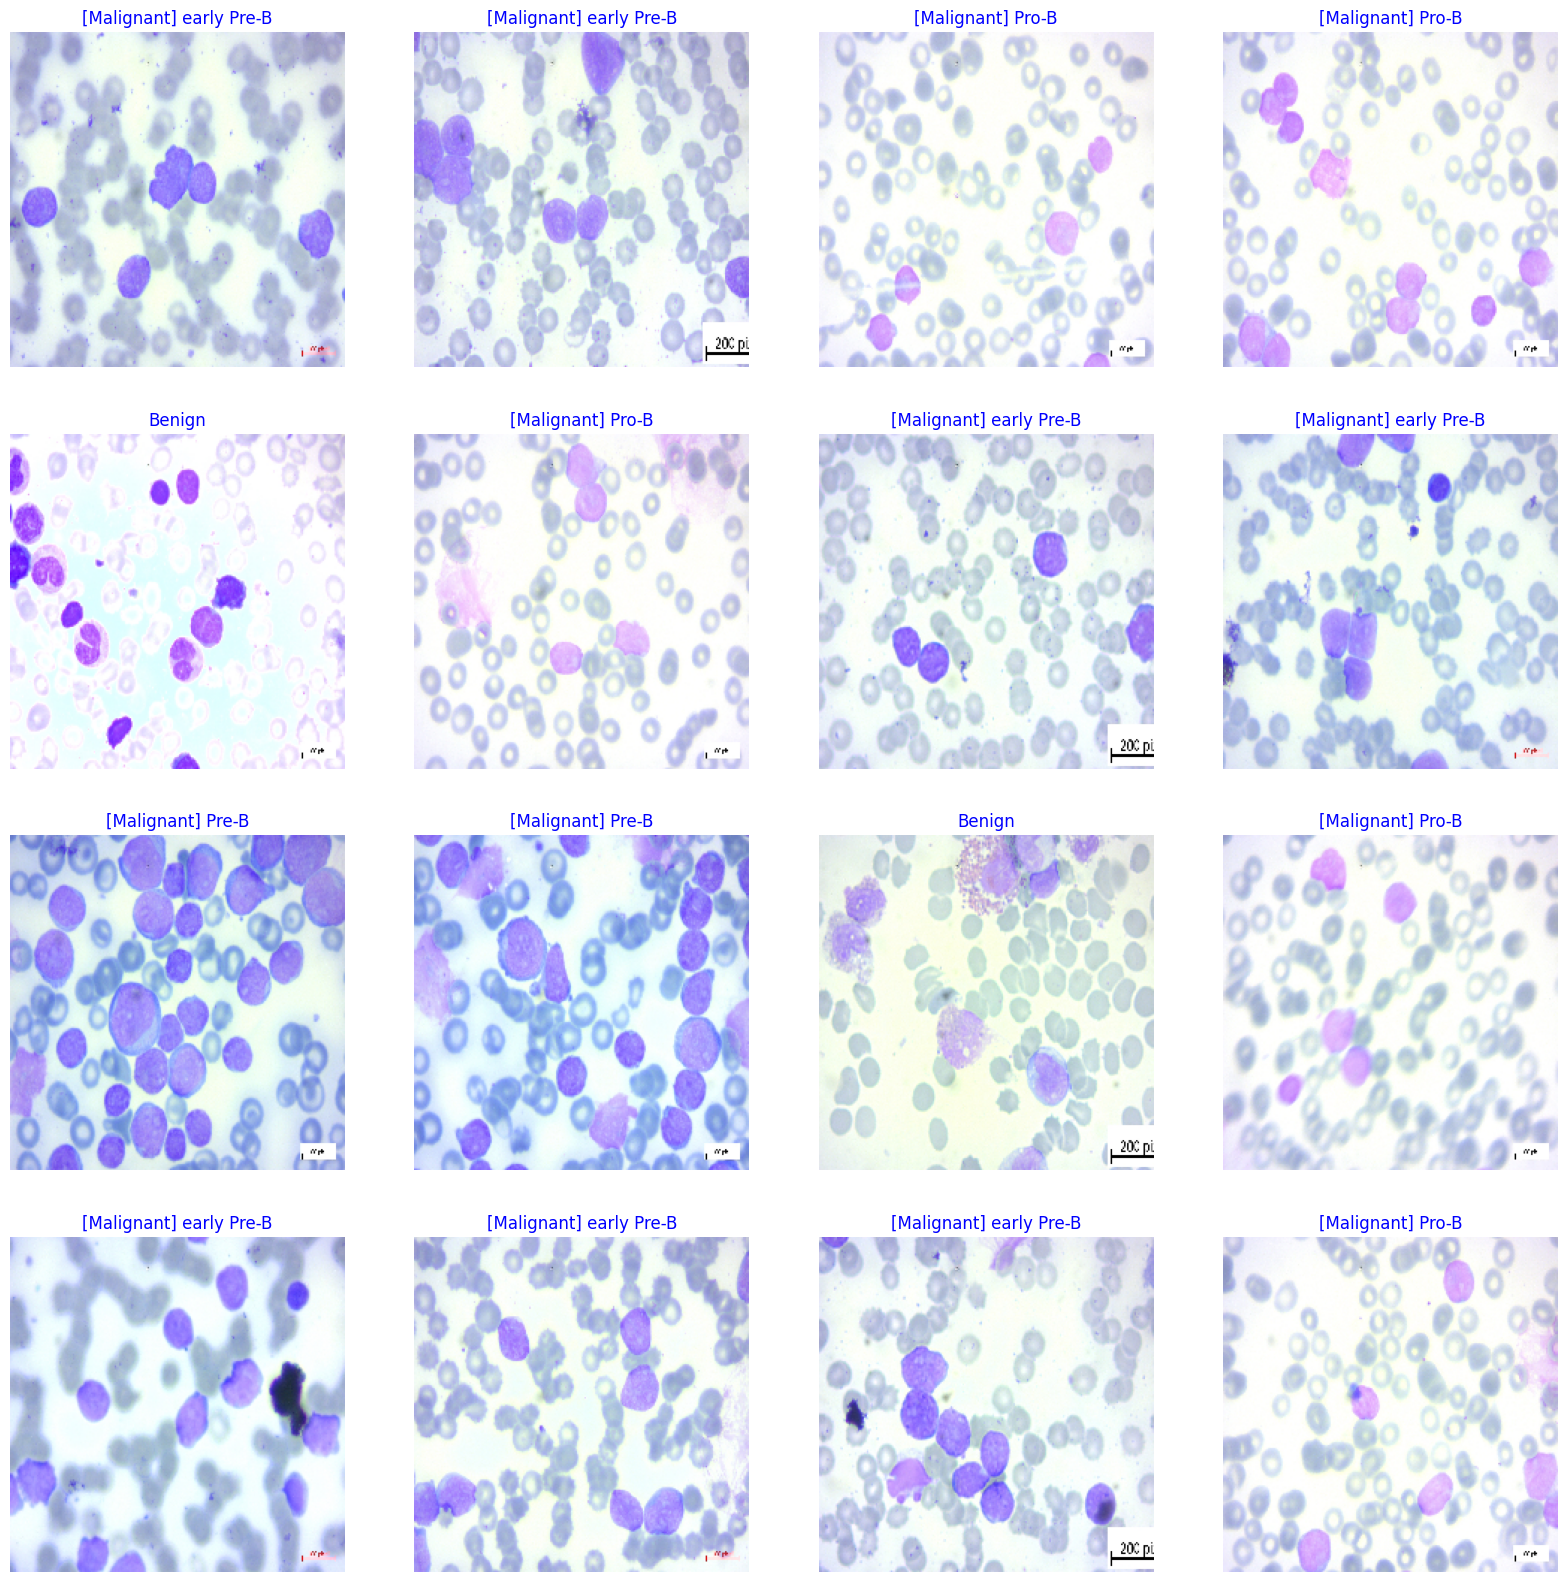

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [11]:
import os
from PIL import Image

# Define the target size
target_size = (224, 224)

# Define the directory paths
original_dir = '/content/Blood cell Cancer [ALL]'
output_dir = '/content/resized_blood_cell_cancer'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get subdirectories (class folders)
for subdir in os.listdir(original_dir):
    subdir_path = os.path.join(original_dir, subdir)

    if os.path.isdir(subdir_path):  # Check if it's a directory
        # Create corresponding output subdirectory
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)

        # Iterate over all images in the current subdirectory
        for image_name in os.listdir(subdir_path):
            image_path = os.path.join(subdir_path, image_name)
            try:
                with Image.open(image_path) as img:
                    # Resize the image
                    img_resized = img.resize(target_size)
                    # Save it to the corresponding output directory
                    output_image_path = os.path.join(output_subdir, image_name)
                    img_resized.save(output_image_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")


MODEL BUILD

In [12]:
# Step 1: Define Model Architecture
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification

    return model

In [13]:
# Step 2: Compile the Model
num_classes = len(classes)  # Number of cancer classes
input_shape = (img_size[0], img_size[1], 3)  # Input shape based on image size and channels

model = create_model(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
images, labels = next(valid_gen)
print(images.shape, labels.shape)


(16, 224, 224, 3) (16, 4)


In [15]:
# Enhanced ImageDataGenerator for training
tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)


Found 2593 validated image filenames belonging to 4 classes.


In [16]:
# Step 4: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.2752 - loss: 13.3279
Test Loss: 12.6554
Test Accuracy: 0.2923


ACCURACY IMPROVEMENT

In [19]:
# Build the model using EfficientNetB3 as the base model
base_model = tf.keras.applications.EfficientNetB3(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Adjust the output layer for 4 classes
])

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for learning rate reduction and early stopping
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(valid_gen),
                    callbacks=[reduce_lr, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 590ms/step - accuracy: 0.5661 - loss: 1.4110 - val_accuracy: 0.8509 - val_loss: 0.4323 - learning_rate: 1.0000e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.8788 - loss: 0.3895
Test Loss: 0.4044
Test Accuracy: 0.8654


PREDICTION

In [21]:
# Step 5: Prediction Function
def predict_cancer_type(image_path, model, class_indices):
    image = Image.open(image_path)
    image = image.resize(img_size)
    image_array = np.array(image) / 255.0  # Normalize
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_name = list(class_indices.keys())[predicted_class[0]]

    return class_name, prediction[0][predicted_class[0]]

# Example usage of the prediction function
# Example usage of the prediction function
test_image_path = '/content/resized_blood_cell_cancer/Benign/Sap_013 (1).jpg'  # Replace with your image path
predicted_class, confidence = predict_cancer_type(test_image_path, model, g_dict)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}')

# Step 6: Generate Alerts for Healthcare Providers
def alert_healthcare_provider(predicted_class, confidence_threshold=0.75):
    if confidence >= confidence_threshold:
        print(f'Alert: High-risk patient detected for class {predicted_class} with confidence {confidence:.2f}. Recommend further screening.')
    else:
        print(f'Prediction for class {predicted_class} is below the confidence threshold. No immediate action required.')

# Example alert generation
alert_healthcare_provider(predicted_class, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: [Malignant] early Pre-B, Confidence: 0.44
Alert: High-risk patient detected for class [Malignant] early Pre-B with confidence 0.44. Recommend further screening.


In [22]:
# Assuming you have a directory with new images for prediction
new_data_dir = '/content/Blood cell Cancer [ALL]'
new_gen = ts_gen.flow_from_directory(new_data_dir, target_size=img_size,
                                     class_mode=None,  # No labels required for prediction
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

# Make predictions
predictions = model.predict(new_gen, steps=len(new_gen))


Found 3242 images belonging to 4 classes.
203/203 ━━━━━━━━━━━━━━━━━━━━ 59s 247ms/step


In [23]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# If you have a mapping of class indices to labels, you can decode the predicted classes
class_labels = new_gen.class_indices
decoded_predictions = [list(class_labels.keys())[list(class_labels.values()).index(i)] for i in predicted_classes]

# Print predictions
for i, label in enumerate(decoded_predictions):
    print(f'Image {i}: Predicted class = {label}')


Image 0: Predicted class = Benign
Image 1: Predicted class = Benign
Image 2: Predicted class = [Malignant] early Pre-B
Image 3: Predicted class = [Malignant] early Pre-B
Image 4: Predicted class = [Malignant] early Pre-B
Image 5: Predicted class = [Malignant] early Pre-B
Image 6: Predicted class = Benign
Image 7: Predicted class = [Malignant] early Pre-B
Image 8: Predicted class = [Malignant] Pre-B
Image 9: Predicted class = Benign
Image 10: Predicted class = [Malignant] Pre-B
Image 11: Predicted class = Benign
Image 12: Predicted class = [Malignant] Pre-B
Image 13: Predicted class = [Malignant] Pre-B
Image 14: Predicted class = [Malignant] Pre-B
Image 15: Predicted class = Benign
Image 16: Predicted class = [Malignant] early Pre-B
Image 17: Predicted class = [Malignant] early Pre-B
Image 18: Predicted class = Benign
Image 19: Predicted class = Benign
Image 20: Predicted class = [Malignant] Pre-B
Image 21: Predicted class = Benign
Image 22: Predicted class = Benign
Image 23: Predicted 

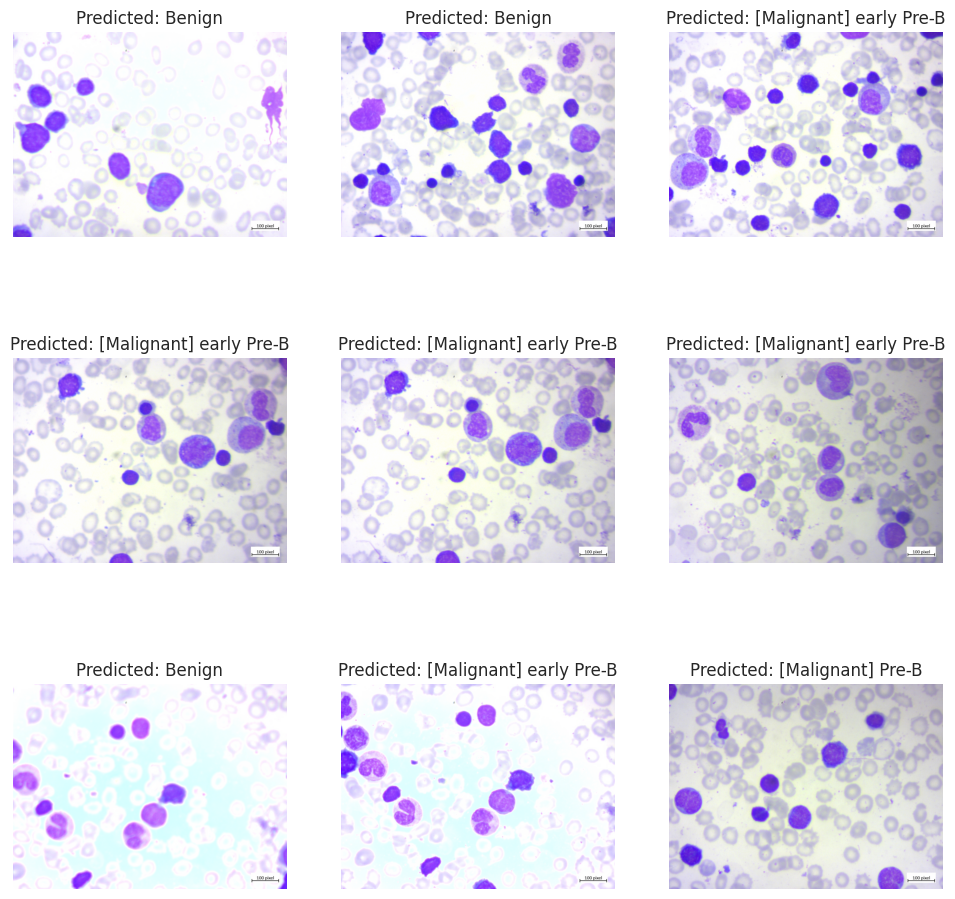

In [24]:
import matplotlib.pyplot as plt

# Display predictions with images
plt.figure(figsize=(12, 12))
for i in range(min(9, len(new_gen.filenames))):  # Display first 9 images
    img = Image.open(new_gen.filepaths[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Predicted: {decoded_predictions[i]}')
    plt.axis('off')
plt.show()
